Mixture-of-Experts (MoE) VLM

*   DeepSeek-VL2-Tiny: 1.0B  
*   DeepSeek-VL2-Small: 2.8B
*   DeepSeek-VL2: 4.5B

In [ ]:
!git clone https://github.com/deepseek-ai/DeepSeek-VL2

In [2]:
%cd DeepSeek-VL2

/content/DeepSeek-VL2


 -e: install a Python package in editable mode.

 (.): Packages are installed from **pyproject.toml** file in current directory.

Edit the pyproject.toml file:
* add "xformers" in dependencies

In [ ]:
!pip install -e .

In [4]:
!pwd

/content/DeepSeek-VL2


In [5]:
import torch
from transformers import AutoModelForCausalLM
from deepseek_vl2.models import DeepseekVLV2Processor, DeepseekVLV2ForCausalLM
from deepseek_vl2.utils.io import load_pil_images

Python version is above 3.10, patching the collections module.


In [6]:
model_path = "deepseek-ai/deepseek-vl2-tiny"
vl_chat_processor: DeepseekVLV2Processor = DeepseekVLV2Processor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: DeepseekVLV2ForCausalLM = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


processor_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



config.json:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/247k [00:00<?, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.74G [00:00<?, ?B/s]

#### visual grounding

**<|ref|> and <|/ref|>** are designed specifically for the **object localization** feature.

In [7]:
conversation = [
    {
        "role": "<|User|>",
        "content": "<image>\n<|ref|>The giraffe at the back.<|/ref|>.",
        "images": ["./images/visual_grounding_1.jpeg"],
    },
    {"role": "<|Assistant|>", "content": ""},
]

In [8]:
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [10]:
outputs = vl_gpt.language.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=False)
print(f"{prepare_inputs['sft_format'][0]}", answer)

<|User|>: <image>
<|ref|>The giraffe at the back.<|/ref|>.

<|Assistant|>: <|ref|>The giraffe at the back.<|/ref|><|det|>[[580, 270, 999, 900]]<|/det|><｜end▁of▁sentence｜>


#### document/table/chart understanding

In [26]:
conversation = [
    {
        "role": "<|User|>",
        "content": " <image>\n This image has one table. What are the columns in this table?",
        "images": ["/content/invoice.webp"],
    },
    {"role": "<|Assistant|>", "content": ""},
]

In [27]:
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

outputs = vl_gpt.language.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=False)
print(f"{prepare_inputs['sft_format'][0]}", answer)

<|User|>: <image>
 This image has one table. What are the columns in this table?

<|Assistant|>: The table has the following columns: No., Description, Qty, Price, Total, Discount, Sub Total.<｜end▁of▁sentence｜>


#### OCR

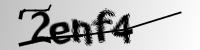

In [30]:
from PIL import Image

image = Image.open("/content/captcha.png")
image

In [28]:
conversation = [
    {
        "role": "<|User|>",
        "content": " <image>\n what are the characters mentioned in this image?",
        "images": ["/content/captcha.png"],
    },
    {"role": "<|Assistant|>", "content": ""},
]

In [29]:
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

outputs = vl_gpt.language.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=False)
print(f"{prepare_inputs['sft_format'][0]}", answer)

<|User|>: <image>
 what are the characters mentioned in this image?

<|Assistant|>: Zenf4<｜end▁of▁sentence｜>


#### multiple images/interleaved image-text

In [7]:
conversation = [
    {
        "role": "<|User|>",
        "content": "This is image_1: <image>\n"
                   "This is image_2: <image>\n Can you tell me what are in the images?",
        "images": [
            "/content/image_1.jpg",
            "/content/image_2.jpg",
        ],
    },
    {"role": "<|Assistant|>", "content": ""}
]

In [8]:
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

outputs = vl_gpt.language.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=False)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<|User|>: This is image_1: <image>
This is image_2: <image>
 Can you tell me what are in the images?

<|Assistant|>: The images depict a rural roadside scene. In the first image, there is a small roadside stall with a blue tarp roof, displaying a variety of fruits, likely coconuts, for sale. There are three people near the stall, with one sitting on a bench and two standing. The second image shows a road with a red auto-rickshaw and a white bus driving on it. The bus has a sign in a non-English script, possibly Sinhala, indicating it might be in Sri Lanka.<｜end▁of▁sentence｜>
